In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import geopandas as gpd
from functools import reduce
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
import matplotlib.patches as mpatches
import warnings
import random
warnings.filterwarnings("ignore")

Below are sections **Data Cleaning**, **Dimension Reduction**, **XGBoost Regression**, **Ridge Regression**

## Data Cleaning

In [2]:
class Data():
    def __init__(self, dfs):
        self.original_dfs = dfs
        self.dfs = dfs
        self.cleaned = False
        self.output = None
        
    def clean(self):
        if self.cleaned:
            return
        for i in range(len(self.dfs)):
            self.dfs[i] = self.dfs[i][self.dfs[i]["availability_30"] > 0]
            self.dfs[i]['occupancy_rate'] =(30 - self.dfs[i]['availability_30']) / 30
            self.dfs[i]["price"] = self.dfs[i]["price"].apply(lambda x: float(x.replace(',','')[1:]))

        merged_df = reduce(lambda left,right: pd.merge(left, right[['id', 'price', 'occupancy_rate']],on='id', how = 'inner', suffixes=('_x', '_y')), self.dfs)
        price_demand = merged_df[['id','price_x', 'price_y', 'occupancy_rate_x', 'occupancy_rate_y']]
        price_demand.columns = ['id','price_1','price_2','price_3','price_4', 'demand_1', 'demand_2', 'demand_3', 'demand_4']
        price_demand = price_demand.merge(df1[['id', 'reviews_per_month']], on='id', how = 'inner').dropna()
        price_demand['demand'] = 1/4*(price_demand['demand_1'] + price_demand['demand_2'] + price_demand['demand_3'] + price_demand['demand_4'])
        price_demand['price'] = 1/4*(price_demand['price_1'] + price_demand['price_2'] + price_demand['price_3'] + price_demand['price_4'])
        df_21 = price_demand.drop(['price_1', "price_2", "price_3", "price_4", 'demand_1', "demand_2", "demand_3", "demand_4"], axis=1).merge(df1[["id", "neighbourhood_cleansed", "bedrooms", "beds", "room_type", "minimum_nights", "amenities", "property_type", "listing_url", "host_since", "review_scores_rating", "calculated_host_listings_count", "accommodates"]], how = 'inner', on=['id'])
        df_21 = df_21[df_21['minimum_nights'] <= 100]
        df_21 = df_21[df_21['demand'] > 0]
        self.output = df_21
        self.dfs = self.original_dfs
        
        
    def add(self, name, func):
        self.output[name] = func(self.output)
        return
    
    def get(self):
        return self.output
    
    def original(self):
        return self.original_dfs
    
    def dropna(self, columns):
        self.output = self.output.dropna(subset=columns)
        return

In [3]:
df1 = pd.read_csv('Data/listings3.csv')
df2 = pd.read_csv('Data/listings6.csv')
df3 = pd.read_csv('Data/listings9.csv')
df4 = pd.read_csv('Data/listings12.csv')
dfs = [df1, df2, df3, df4]


In [4]:
data = Data(dfs)

In [5]:
data.clean()
data.add("price_per_person", lambda x: x['price']/x['accommodates'])
data.dropna(['room_type', "price_per_person", "review_scores_rating", "accommodates", "room_type"])

In [6]:
df = data.get()

In [7]:
df['log_demand'] = np.log((df['demand'])/(1-df['demand']))

<AxesSubplot:>

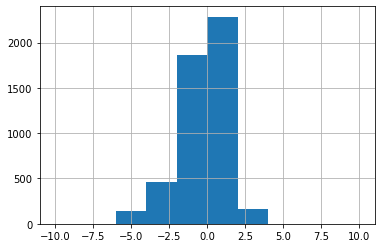

In [8]:
df.replace([np.inf, -np.inf], -50, inplace=True)
df['log_demand'].hist(range=(-10,10))

In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder

In [10]:
df = data.get()

In [11]:
df = df.dropna()

In [12]:
df.columns

Index(['id', 'reviews_per_month', 'demand', 'price', 'neighbourhood_cleansed',
       'bedrooms', 'beds', 'room_type', 'minimum_nights', 'amenities',
       'property_type', 'listing_url', 'host_since', 'review_scores_rating',
       'calculated_host_listings_count', 'accommodates', 'price_per_person',
       'log_demand'],
      dtype='object')

#### Zillow Housing data

In [13]:
import geopy

In [14]:
neighborhood_location = df1.groupby('neighbourhood_cleansed').mean()[['longitude', 'latitude']]

In [15]:
neighborhood_location = np.round(neighborhood_location[['longitude','latitude']], 5)

In [16]:
def get_zipcode(df, geolocator, lat_field, lon_field):
    location = geolocator.reverse((df[lat_field], df[lon_field]))
    if 'postcode' in location.raw['address'].keys():
        return location.raw['address']['postcode']
    else:
        return 0


geolocator = geopy.Nominatim(user_agent='Jiayang_Nie')

zipcodes = neighborhood_location.apply(get_zipcode, axis=1, geolocator=geolocator, lat_field='latitude', lon_field='longitude')

In [17]:
zipcodes['Agua Dulce'] = '91390'
zipcodes['Angeles Crest'] = '91011'
zipcodes['Ridge Route'] = '93225'
zipcodes['Tujunga Canyons'] = '91042'
zipcodes['Unincorporated Catalina Island'] = '90704'
zipcodes['Unincorporated Santa Susana Mountains'] = '93063'
zipcodes['Leona Valley'] = '93551'

In [18]:
zipcodes = zipcodes.apply(lambda x: x[0:5]).astype(int)

In [19]:
zipcodes = zipcodes.to_frame().reset_index()
zipcodes.columns = ['neighbourhood_cleansed', 'zipcode']

In [20]:
zipcodes

,neighbourhood_cleansed,zipcode
0,Acton,93510
1,Adams-Normandie,90007
2,Agoura Hills,91301
3,Agua Dulce,91390
4,Alhambra,91801
...,...,...
258,Willowbrook,90059
259,Wilmington,90744
260,Windsor Square,90004
261,Winnetka,91306


In [21]:
df = pd.merge(df, zipcodes, on = 'neighbourhood_cleansed')

In [22]:
one_bed = pd.read_csv("Data/zillow_1bed.csv")
two_bed = pd.read_csv("Data/zillow_2bed.csv")
three_bed = pd.read_csv("Data/zillow_3bed.csv")
four_bed = pd.read_csv("Data/zillow_4bed.csv")
five_bed = pd.read_csv("Data/zillow_5bed.csv")

In [23]:
def look_for(row):
    nbeds = row['bedrooms']
    zipcode = row['zipcode']
    if nbeds == 1:
        toReturn = one_bed[one_bed['RegionID'] == zipcode]['2021-12-31']
    elif nbeds == 2:
        toReturn = two_bed[two_bed['RegionID'] == zipcode]['2021-12-31']
    elif nbeds == 3:
        toReturn = three_bed[three_bed['RegionID'] == zipcode]['2021-12-31']
    elif nbeds == 4:
        toReturn = four_bed[four_bed['RegionID'] == zipcode]['2021-12-31']
    else:
        toReturn = five_bed[five_bed['RegionID'] == zipcode]['2021-12-31']
    while toReturn.empty:
        zipcode += 1
        if nbeds == 1:
            toReturn = one_bed[one_bed['RegionID'] == zipcode]['2021-12-31']
        elif nbeds == 2:
            toReturn = two_bed[two_bed['RegionID'] == zipcode]['2021-12-31']
        elif nbeds == 3:
            toReturn = three_bed[three_bed['RegionID'] == zipcode]['2021-12-31']
        elif nbeds == 4:
            toReturn = four_bed[four_bed['RegionID'] == zipcode]['2021-12-31']
        else:
            toReturn = five_bed[five_bed['RegionID'] == zipcode]['2021-12-31']
    return toReturn.iloc[0]

a = df.apply(look_for, axis=1)
            
            
            

In [24]:
df['housing_price'] = a

## Dimension Reduction

We performed dimension reduction using principal component analysis to reduce the time and storage space required. It also helps remove multi-collinearity which improves the interpretation of the parameters of the machine learning model. We one encoded the variable property type and reduced the dimensionality of the amenities column.

In [25]:
import tensorflow as tf
from tensorflow.keras import layers
from gensim.models import Word2Vec, KeyedVectors
from spacy.lang.en import English

In [26]:
from sklearn.decomposition import PCA
from prince import MCA

In [27]:
enc_ohe = OneHotEncoder()
enc_ohe.fit(df[["property_type"]])
property_types = pd.DataFrame(enc_ohe.transform(df[["property_type"]]).toarray(), columns=enc_ohe.get_feature_names(['property_type']))

In [28]:
property_types

,property_type_Barn,property_type_Boat,property_type_Camper/RV,property_type_Castle,property_type_Earth house,property_type_Entire apartment,property_type_Entire bungalow,property_type_Entire cabin,property_type_Entire condominium,property_type_Entire cottage,...,property_type_Shared room in guesthouse,property_type_Shared room in hostel,property_type_Shared room in house,property_type_Shared room in townhouse,property_type_Shared room in villa,property_type_Tent,property_type_Tiny house,property_type_Train,property_type_Treehouse,property_type_Yurt
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4345,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4346,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4347,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4348,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [29]:
mca_property = MCA(n_components = 10, n_iter = 100, random_state = 101)
mca_property.fit(property_types)
property_mca = mca_property.transform(property_types)
property_mca.head()

,0,1,2,3,4,5,6,7,8,9
0,-0.290535,1.248899,0.375204,0.410369,-0.260504,-0.439425,0.125002,-0.454747,0.095764,0.491575
1,-1.374753,0.420110,-1.392814,0.208893,-0.857608,0.423394,0.424964,-0.933427,-0.231283,-0.323049
2,0.008975,0.223149,0.152499,-0.098690,-0.493820,0.076540,-0.193167,0.232183,-0.054293,0.039948
3,-1.374753,0.420110,-1.392814,0.208893,-0.857608,0.423394,0.424964,-0.933427,-0.231283,-0.323049
4,-0.336741,0.188656,0.049187,-0.227963,0.067116,-0.367054,-0.197501,0.083895,0.212545,-0.323280


In [30]:
property_mca.columns = ["property_"+str(i) for i in range(10)]

In [31]:
df = pd.concat([df.reset_index(drop=True), property_mca], axis=1).drop("property_type", axis=1)

In [32]:
amen = {}
stop_words = set([' ', '!', '"', '$', '%', '&', "'s", '(', ')', '*', '+', ',','-','--','-rain','.','/','0','1','10','100','1000','100\\','12','125\\','14','140','15\\','180','184','196','2','200','25','26','260','3','300','30\\','32\\','33\\','360','365','4','400','40\\','42\\','43\\','44\\','45','45\\','46\\','48\\','5','50','500','50\\','54\\','55\\','58\\','6','60\\','65\\','70','72\\','75','75\\','8',':',';','\\u2013','\\u2013\\u00a0','\\u2019n', 'a'])
nlp = English()
for amenity in df['amenities']:
    
    amenity = amenity[2:-2].split('", "')
    for a in amenity:
        a = a.lower()
        tokens = nlp(a)
        for token in tokens:
            token = str(token)
            if token in stop_words:
                continue
            elif token not in amen:
                amen[token] = 1
            else:
                amen[token] += 1


In [33]:
threshold = np.quantile(list(amen.values()), 0.75)
amens = []
for key in amen.keys():
    if amen[key] >= threshold:
        amens.append(key)

In [34]:
amens

['stove',
 'cooking',
 'basics',
 'bathtub',
 'kitchen',
 'hangers',
 'essentials',
 'iron',
 'oven',
 'heating',
 'hair',
 'dryer',
 'long',
 'term',
 'stays',
 'allowed',
 'hot',
 'water',
 'lock',
 'on',
 'bedroom',
 'door',
 'dedicated',
 'workspace',
 'smoke',
 'alarm',
 'refrigerator',
 'shampoo',
 'host',
 'greets',
 'you',
 'dishes',
 'and',
 'silverware',
 'carbon',
 'monoxide',
 'wifi',
 'free',
 'street',
 'parking',
 'first',
 'aid',
 'kit',
 'garden',
 'or',
 'backyard',
 'patio',
 'balcony',
 'washer',
 'in',
 'tv',
 'coffee',
 'maker',
 'fire',
 'extinguisher',
 'bed',
 'linens',
 'luggage',
 'dropoff',
 'extra',
 'pillows',
 'blankets',
 'paid',
 'premises',
 'bbq',
 'grill',
 'microwave',
 'beach',
 'cable',
 'single',
 'level',
 'home',
 'private',
 'entrance',
 'cleaning',
 'before',
 'checkout',
 'keypad',
 'air',
 'conditioning',
 'indoor',
 'fireplace',
 'pack',
 'play',
 'travel',
 'crib',
 'children\\u2019s',
 'books',
 'toys',
 'high',
 'chair',
 'dishwasher',


In [35]:
amenities = np.zeros((df.shape[0], len(amens)))
for i in range(len(df['amenities'])):
    for j in range(len(amens)):
        if amens[j] in df['amenities'][i].lower():
            amenities[i][j] = 1

In [36]:
amenities = pd.DataFrame(amenities)

In [37]:
mca_amenities = MCA(n_components = 20, n_iter = 100, random_state = 101)
mca_amenities.fit(amenities)
amenities_mca = mca_amenities.transform(amenities)
amenities_mca.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,-0.370939,-0.031194,0.131290,0.486422,0.168785,-0.182657,-0.243678,-0.141406,-0.003097,-0.209760,0.080214,0.117218,-0.022090,-0.197276,0.161139,0.030988,0.014653,-0.105163,-0.127009,-0.069637
1,-0.305792,-0.168682,-0.172469,0.458294,-0.036251,-0.311695,-0.234055,0.158255,-0.074214,-0.150494,0.088534,0.226660,0.049344,-0.104863,-0.032984,-0.012418,-0.052195,0.007554,0.090452,-0.129868
2,-0.424324,0.179825,0.407742,-0.182556,0.356497,0.169733,-0.313004,-0.118155,0.092319,-0.205103,0.138905,0.202242,0.280056,0.115129,-0.350704,0.192681,0.188240,0.110365,0.130408,0.078422
3,-0.006995,-0.126599,-0.320308,0.005773,-0.036203,0.000057,0.095331,-0.156269,-0.137340,-0.063090,-0.013979,-0.074006,0.225954,0.093110,-0.017522,-0.354896,-0.092516,0.173308,-0.127325,-0.065524
4,0.151567,-0.155192,-0.124486,0.046168,0.641510,0.137467,0.536231,0.132706,0.155277,0.098564,-0.036247,0.058902,0.138810,-0.059429,0.068377,0.027453,-0.006056,0.079366,-0.120933,-0.029844


In [38]:
amenities_mca.columns = ["amenity_"+str(i) for i in range(amenities_mca.shape[1])]

In [39]:
df = pd.concat([df.reset_index(drop=True), amenities_mca], axis=1).drop("amenities", axis=1)

In [40]:
df = df.dropna()

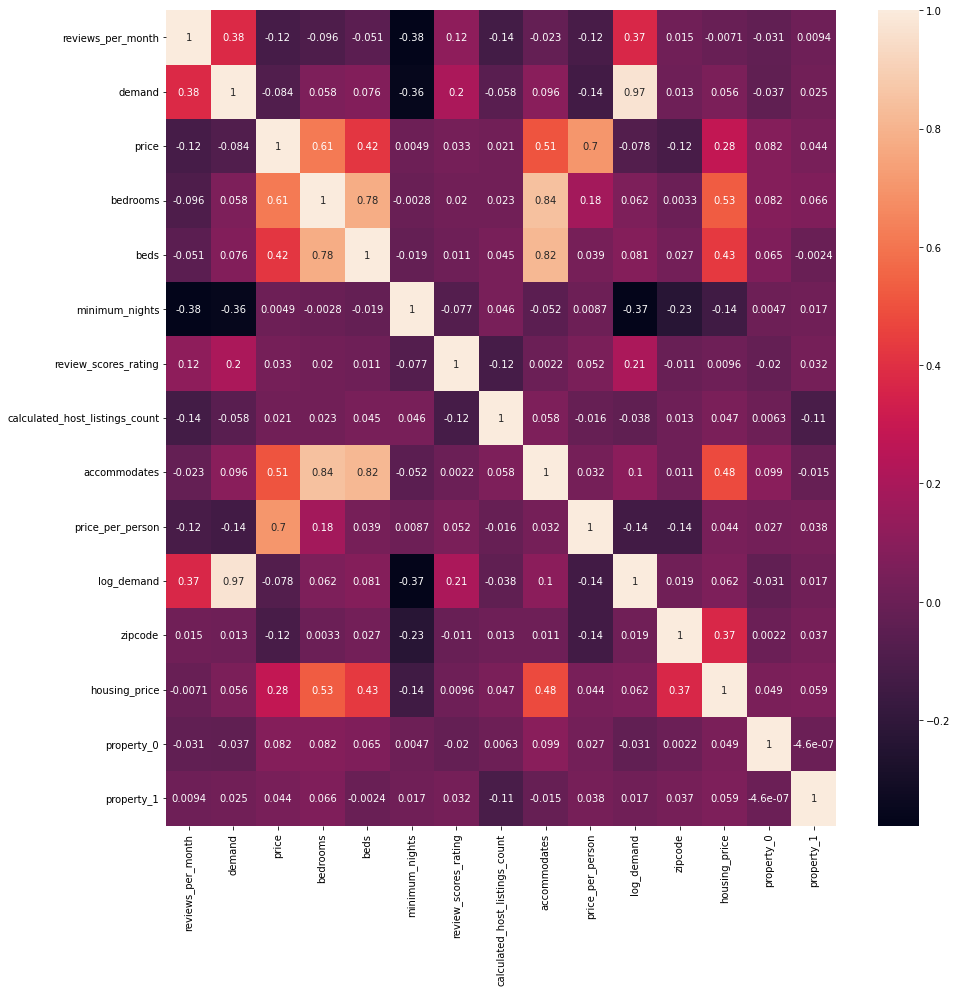

In [41]:
matrix = df.iloc[:,1:20].corr(method = 'pearson')
plt.figure(figsize=(15,15))
sns.heatmap(matrix, annot=True)
plt.show()

We see that Demand does not have a high correlation with other independent variables that we are using to build the model to predict demand therefore we can move on to building models to use all the variables to predict demand.

## XGBoost Regression

In [42]:
# conda install py-xgboost
import xgboost as xgb
from random import uniform
from random import randint
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

In [43]:
df.columns

Index(['id', 'reviews_per_month', 'demand', 'price', 'neighbourhood_cleansed',
       'bedrooms', 'beds', 'room_type', 'minimum_nights', 'listing_url',
       'host_since', 'review_scores_rating', 'calculated_host_listings_count',
       'accommodates', 'price_per_person', 'log_demand', 'zipcode',
       'housing_price', 'property_0', 'property_1', 'property_2', 'property_3',
       'property_4', 'property_5', 'property_6', 'property_7', 'property_8',
       'property_9', 'amenity_0', 'amenity_1', 'amenity_2', 'amenity_3',
       'amenity_4', 'amenity_5', 'amenity_6', 'amenity_7', 'amenity_8',
       'amenity_9', 'amenity_10', 'amenity_11', 'amenity_12', 'amenity_13',
       'amenity_14', 'amenity_15', 'amenity_16', 'amenity_17', 'amenity_18',
       'amenity_19'],
      dtype='object')

In [44]:
df = df[df['demand'] > 0]

In [45]:
model_df = df.drop(["id", "listing_url", "price", "neighbourhood_cleansed", "log_demand", "demand", "zipcode", "host_since"], axis=1)

X_train, X_test, y_train, y_test = train_test_split(model_df, df['demand'], test_size=0.1, random_state=42)

In [46]:
# model_df.to_csv("cleaned_data.csv")

In [47]:
cat_cols = X_train.columns[X_train.dtypes == 'object']
num_cols = X_train.columns[(X_train.dtypes == 'float64') | (X_train.dtypes == 'int64')]

In [48]:
enc_ohe = OneHotEncoder()
enc_ohe.fit(X_train[cat_cols])
def OneHotEncoding(df, enc, categories):  
    transformed = pd.DataFrame(enc.transform(df[categories]).toarray(), columns=enc.get_feature_names(categories))
    return pd.concat([df.reset_index(drop=True), transformed], axis=1).drop(categories, axis=1)
X_train = OneHotEncoding(X_train, enc_ohe, cat_cols)
X_test = OneHotEncoding(X_test, enc_ohe, cat_cols)

In [49]:
X_train

,reviews_per_month,bedrooms,beds,minimum_nights,review_scores_rating,calculated_host_listings_count,accommodates,price_per_person,housing_price,property_0,...,amenity_14,amenity_15,amenity_16,amenity_17,amenity_18,amenity_19,room_type_Entire home/apt,room_type_Hotel room,room_type_Private room,room_type_Shared room
0,6.34,1.0,1.0,1,100.0,1,2,50.750000,42001.0,-0.290535,...,-0.069205,-0.051025,0.284090,-0.139299,-0.025393,0.056822,0.0,0.0,1.0,0.0
1,1.43,1.0,1.0,2,91.0,7,2,17.750000,65817.0,-0.336741,...,0.035759,-0.168579,0.028979,-0.085430,0.145633,-0.150851,0.0,0.0,1.0,0.0
2,0.24,3.0,3.0,29,86.0,8,8,21.250000,218516.0,1.407742,...,0.260605,0.302044,-0.256651,-0.046598,-0.180593,0.029684,1.0,0.0,0.0,0.0
3,1.70,1.0,1.0,5,91.0,1,2,26.875000,82599.0,0.992363,...,0.154492,-0.166164,0.216836,-0.023030,0.028158,-0.217092,0.0,0.0,1.0,0.0
4,1.28,1.0,1.0,30,96.0,1,1,53.750000,24708.0,-0.336741,...,-0.131405,-0.080430,0.027267,-0.083142,0.018889,0.011682,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3909,4.78,1.0,1.0,2,96.0,2,3,48.416667,79283.0,0.221260,...,0.078226,-0.013848,-0.163939,0.004386,0.044443,0.073366,1.0,0.0,0.0,0.0
3910,0.03,1.0,1.0,30,80.0,1,2,60.000000,63570.0,1.278649,...,-0.331161,0.104192,-0.107778,0.055833,0.253992,0.170858,0.0,0.0,1.0,0.0
3911,0.37,1.0,1.0,7,70.0,10,2,35.250000,169810.0,0.992363,...,0.156886,0.100485,-0.241726,0.128317,0.036290,-0.104492,0.0,0.0,1.0,0.0
3912,1.17,1.0,0.0,2,73.0,12,1,37.000000,106634.0,-0.290535,...,0.202294,0.089140,0.208122,-0.022923,-0.322502,-0.003909,0.0,0.0,1.0,0.0


In [50]:
params = {'learning_rate': np.arange(0.001, 0.1, (0.1-0.001)/5), # default 0.1 
          'max_depth': np.arange(2, 6, 1), # default 3
          'n_estimators': np.arange(100, 250, 50)}
xgb_model = xgb.XGBRegressor(random_state=42)

In [51]:
xgb_search = GridSearchCV(xgb_model, params, cv=5)

In [52]:
%time xgb_search.fit(X_train, y_train, verbose = 1)

CPU times: user 15min 21s, sys: 9.82 s, total: 15min 31s
Wall time: 5min 4s


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    enable_categorical=False, gamma=None,
                                    gpu_id=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs=None,
                                    num_parallel_tree=None, predictor=None,
                                    random_state=42, reg_alpha=None,
                                    reg_lambda=None, scale_pos_weight=None,
         

In [53]:
xgb_search.best_params_

{'learning_rate': 0.040600000000000004, 'max_depth': 5, 'n_estimators': 200}

In [54]:
fi_dict = dict()
for x, y in zip(xgb_search.best_estimator_.get_booster().feature_names, xgb_search.best_estimator_.feature_importances_):
    fi_dict[x] = y

In [55]:
fi_list = [[x, y] for x, y in zip(xgb_search.best_estimator_.get_booster().feature_names, xgb_search.best_estimator_.feature_importances_)]

In [56]:
fi_list.sort(key = lambda x: -x[1])

In [57]:
fi_list[:20]

[['room_type_Entire home/apt', 0.18335262],
 ['reviews_per_month', 0.098629825],
 ['minimum_nights', 0.06959043],
 ['calculated_host_listings_count', 0.037744895],
 ['property_2', 0.03447316],
 ['review_scores_rating', 0.028745055],
 ['price_per_person', 0.026709817],
 ['amenity_0', 0.023896959],
 ['amenity_1', 0.023382472],
 ['property_9', 0.021260388],
 ['property_5', 0.019821914],
 ['property_1', 0.0192547],
 ['property_6', 0.018509384],
 ['room_type_Hotel room', 0.017536595],
 ['amenity_9', 0.017356057],
 ['room_type_Private room', 0.0171431],
 ['amenity_6', 0.01698206],
 ['amenity_10', 0.016458223],
 ['amenity_3', 0.015534099],
 ['property_0', 0.015289482]]

## Model Evaluation

In [58]:
import shap
from sklearn.model_selection import cross_validate

In [59]:
model = xgb_search.best_estimator_.fit(X_train, y_train)

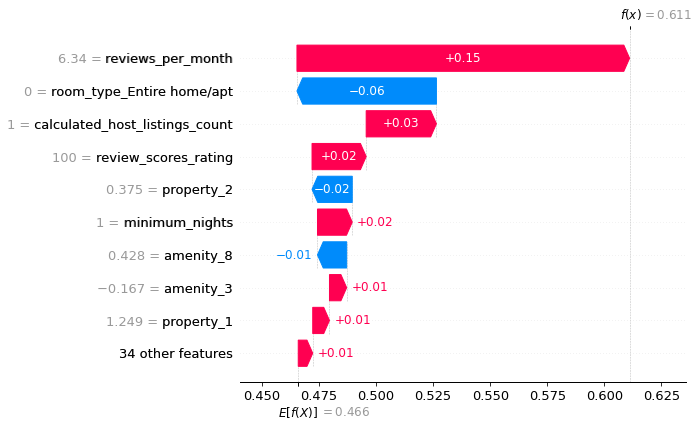

In [60]:
explainer = shap.Explainer(model)
shap_values = explainer(X_train)

# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[0])

#### Mean Squared Error for XGBoost

In [61]:
print('Error for XGBoost is: ', np.mean((xgb_search.best_estimator_.predict(X_test)-y_test)**2))

Error for XGBoost is:  0.03666768540028545


### CV permute feature importance

In [62]:
feature_importance = {}
for columns in X_train.columns:
    old_column = X_train[columns].copy()
    X_train[columns] = np.random.permutation(X_train[columns])
    model = xgb_search.best_estimator_
    cv_results = cross_validate(model, X_train, y_train, cv=5)
    feature_importance[columns] = np.mean(cv_results['test_score'])
    X_train[columns] = old_column
    

In [63]:
feature_importance # The bigger the better

{'reviews_per_month': 0.4097085527123741,
 'bedrooms': 0.4360915998050636,
 'beds': 0.43683234081189176,
 'minimum_nights': 0.3845514000202171,
 'review_scores_rating': 0.42831588705001067,
 'calculated_host_listings_count': 0.41889315507409774,
 'accommodates': 0.4341130644684383,
 'price_per_person': 0.4025492057787633,
 'housing_price': 0.4341429717627988,
 'property_0': 0.437792723202563,
 'property_1': 0.4378443430730969,
 'property_2': 0.4384851953719469,
 'property_3': 0.4378417553200517,
 'property_4': 0.43377528772960466,
 'property_5': 0.43761338565446417,
 'property_6': 0.43603847774358134,
 'property_7': 0.43895620053953327,
 'property_8': 0.4369240218621191,
 'property_9': 0.4381916756014605,
 'amenity_0': 0.43587681570204406,
 'amenity_1': 0.43398658390518163,
 'amenity_2': 0.43307529847242954,
 'amenity_3': 0.43359926896787593,
 'amenity_4': 0.4366246300266671,
 'amenity_5': 0.4364783094382741,
 'amenity_6': 0.4378521274157562,
 'amenity_7': 0.4349605715602719,
 'amenity

### StandardScaler

In [64]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler().fit(X_train.iloc[:,:-4])

In [65]:
transformed = pd.DataFrame(scaler.transform(X_train.iloc[:,:-4]), columns=X_train.columns[:-4])
X_train = pd.concat([transformed, X_train.iloc[:,-4:]], axis=1)

In [66]:
transformed = pd.DataFrame(scaler.transform(X_test.iloc[:,:-4]), columns=X_test.columns[:-4])
X_test = pd.concat([transformed, X_test.iloc[:,-4:]], axis=1)

## Ridge Regression

In [133]:
from sklearn.linear_model import Ridge
from sklearn.metrics import classification_report


In [68]:
ridge = Ridge()

In [69]:
params = {'alpha': np.arange(0.1, 2, 0.5)}

In [70]:
ridge_search = GridSearchCV(ridge, params, cv=5)

In [71]:
ridge_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': array([0.1, 0.6, 1.1, 1.6])})

In [72]:
ft = [[x,y] for x, y in zip(list(X_train.columns),ridge_search.best_estimator_.coef_)]

In [73]:
ft.sort(key = lambda x: -np.abs(x[1]))

In [74]:
ft

[['room_type_Entire home/apt', 0.15142253295788655],
 ['room_type_Hotel room', -0.13382638842459538],
 ['minimum_nights', -0.06025420955029661],
 ['reviews_per_month', 0.04447020202917307],
 ['price_per_person', -0.037516407488838846],
 ['accommodates', -0.03175450877932462],
 ['review_scores_rating', 0.02989609252401511],
 ['amenity_6', -0.024433636595906232],
 ['room_type_Shared room', -0.021325956414696545],
 ['amenity_0', 0.02045626832158512],
 ['amenity_9', -0.018121375834557203],
 ['amenity_3', -0.015022629468831695],
 ['beds', 0.013582116166490235],
 ['property_1', 0.013330494588330702],
 ['amenity_2', -0.01252474662841929],
 ['amenity_19', 0.012403702600055052],
 ['amenity_11', 0.012235620364144884],
 ['property_9', -0.00855946848263961],
 ['amenity_8', -0.007939327634001708],
 ['amenity_15', -0.007155147136877754],
 ['property_4', -0.007060177934034913],
 ['amenity_12', 0.006995253406905268],
 ['property_8', 0.0062882520748551675],
 ['property_5', 0.005280861871677963],
 ['ame

#### Mean Squared Error for Ridge Regression

In [75]:
print('Error for Ridge Regressor is: ', np.mean((ridge_search.best_estimator_.predict(X_test)-y_test)**2))

Error for Ridge Regressor is:  0.04357804588075323


In [76]:
print('Error for just guessing the mean is: ', np.var(y_test))

Error for just guessing the mean is:  0.06736333362692852


## Random Forest Regressor

In [103]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error


In [94]:
rfc = RandomForestRegressor(n_jobs=-1,max_features= 'sqrt' ,n_estimators=50, oob_score = True) 

param_grid = { 
    'n_estimators': np.arange(1, 100, 1),
    'max_features': ['auto', 'sqrt', 'log2']
}
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
CV_rfc.fit(X_train, y_train)
print(CV_rfc.best_params_)


{'max_features': 'auto', 'n_estimators': 68}


In [139]:
# X_train, X_test, y_train, y_test = train_test_split(model_df, df.demand, test_size=0.1, random_state=42)
regressor = RandomForestRegressor(max_features = 'auto', n_estimators = 68)
regressor.fit(X_train, y_train) 


RandomForestRegressor(n_estimators=68)

In [140]:
Y_pred = regressor.predict(X_test)  
regressor.feature_importances_


array([2.32415945e-01, 2.57524904e-03, 6.47434094e-03, 5.62655883e-02,
       2.36564843e-02, 4.59326243e-02, 8.13521952e-03, 5.60320954e-02,
       2.26694091e-02, 4.91423741e-03, 5.87101287e-03, 4.71506856e-03,
       4.21592618e-03, 4.01686165e-03, 6.84411833e-03, 4.94273047e-03,
       3.89230235e-03, 4.98102077e-03, 2.89858487e-03, 2.63328126e-02,
       2.47888101e-02, 1.86977161e-02, 2.34305182e-02, 2.13068152e-02,
       1.85356373e-02, 2.49030190e-02, 2.04526466e-02, 2.03977076e-02,
       2.38127334e-02, 1.87921322e-02, 1.97233903e-02, 2.11349017e-02,
       2.09609265e-02, 1.92270662e-02, 2.25560872e-02, 2.03400487e-02,
       2.15468278e-02, 1.95198289e-02, 2.48427155e-02, 6.63057141e-02,
       7.29774470e-04, 1.71267641e-04, 4.20837525e-05])

<AxesSubplot:xlabel='demand', ylabel='Density'>

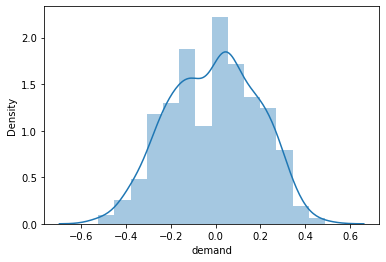

In [141]:
sns.distplot(y_test-Y_pred)

#### Mean Squared Error for Random Forest

In [142]:
print('Error for Random Forest is :' , mean_squared_error(y_test, Y_pred))

Error for Random Forest is : 0.03791190839785317


In [161]:
#print(classification_report(y_test, Y_pred))

## Decision Tree

In [152]:
from sklearn.model_selection import StratifiedKFold
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import accuracy_score

In [153]:
dt = DecisionTreeRegressor()
dt.fit(X_train, np.ravel(y_train, order = 'C'))


DecisionTreeRegressor()

In [154]:
dt.fit(X_train, y_train)


DecisionTreeRegressor()

In [184]:
Y_pred = regressor.predict(X_test)  
Y_pred

array([0.48737745, 0.51041667, 0.59705882, 0.54227941, 0.2879902 ,
       0.2067402 , 0.56752451, 0.51323529, 0.13051471, 0.60428922,
       0.60379902, 0.52781863, 0.60355392, 0.67267157, 0.39767157,
       0.34546569, 0.77904412, 0.67598039, 0.3432598 , 0.67757353,
       0.68627451, 0.41642157, 0.63394608, 0.59840686, 0.5372549 ,
       0.47169118, 0.38590686, 0.53161765, 0.43357843, 0.44522059,
       0.59166667, 0.39693627, 0.54301471, 0.35220588, 0.2564951 ,
       0.17683824, 0.49816176, 0.4129902 , 0.49534314, 0.50355392,
       0.50894608, 0.68333333, 0.67659314, 0.43223039, 0.51053922,
       0.52928922, 0.3754902 , 0.53958333, 0.40098039, 0.58578431,
       0.58615196, 0.42634804, 0.24571078, 0.34117647, 0.71654412,
       0.55772059, 0.43026961, 0.57377451, 0.35735294, 0.32218137,
       0.57230392, 0.36176471, 0.39473039, 0.51948529, 0.57328431,
       0.57696078, 0.41666667, 0.47745098, 0.69448529, 0.46323529,
       0.63480392, 0.71323529, 0.40220588, 0.39129902, 0.37867

#### Mean Squared Error for Decision Tree

In [156]:
print('Error for Random Forest is :' , mean_squared_error(y_test, Y_pred))

Error for Random Forest is : 0.03791190839785317


In [160]:
#print(classification_report(y_test, Y_pred))
# accuracy_score(y_test, Y_pred, normalize=False)

## Epsilon-Support Vector Regression

In [173]:
from sklearn import svm
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [181]:
svr = make_pipeline(StandardScaler(), SVR(C=1.0, epsilon=0.2))
svr.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svr', SVR(epsilon=0.2))])

In [182]:
Y_pred = svr.predict(X_test)  
Y_pred

array([0.5531335 , 0.57105382, 0.67833849, 0.42410895, 0.29560283,
       0.25912635, 0.49151695, 0.44477011, 0.24262289, 0.54305137,
       0.65941466, 0.487716  , 0.61503582, 0.59144989, 0.57250044,
       0.12793863, 0.67088329, 0.59579277, 0.32011973, 0.65878424,
       0.66968731, 0.57314816, 0.45142864, 0.574984  , 0.46682103,
       0.5523659 , 0.48873334, 0.47626163, 0.42582691, 0.42746152,
       0.70862091, 0.37923097, 0.55001628, 0.36166038, 0.21677175,
       0.1487038 , 0.54116894, 0.40167861, 0.45958599, 0.63469144,
       0.55704224, 0.6639957 , 0.65968335, 0.34153531, 0.55456012,
       0.43270259, 0.51861907, 0.30810694, 0.40360868, 0.44947914,
       0.77218758, 0.6144874 , 0.27269142, 0.27270015, 0.7088238 ,
       0.60075677, 0.36385851, 0.5520563 , 0.35960894, 0.35221772,
       0.45687648, 0.44363903, 0.4406242 , 0.52028506, 0.45793097,
       0.49156713, 0.41327215, 0.48960711, 0.50974715, 0.47673168,
       0.66964417, 0.60624501, 0.44627561, 0.40914007, 0.34281

#### Mean Squared Error for Epsilon-Support Vector Regression 

In [183]:
print('Error for Random Forest is :' , mean_squared_error(y_test, Y_pred))

Error for Random Forest is : 0.03983761340794757
